# Building a methylation-informed regulatory network
Daniel C Morgan<sup>1</sup>

<sup>1</sup>Channing Division of Network Medicine, Harvard Medical School, Boston, MA.

## Introduction

Inexpensive, high quality methylation platforms (illumina 450k/850k arrays) have shifted the prospect of integrating such omics into more traditional resources for the inference of gene regulatory networks (GRN). The recent literature has expanded in every direction to take advantage of this new, ubiquitous data source, and as such a wide range of approaches have been proposed. Recent publications range from potential use cases where it makes the most sense to account for DNA methylation in regulatory framework to methodological approaches for doing just that without regard for the research question. This book chapter is organized based upon this continuum, starting with use cases most appropriate for taking advantage of DNA methylation information towards more recent approaches of methodologies and frameworks for appropriately and accurately doing so. Lastly, we shall work through a modern approach for both, namely a meGRN framework and use case example, to see the utility methylation can lend to an investigation.

## Loading libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import scipy
import pandas as pd
from sklearn import metrics
# from pybedtools import BedTool ##super limited capabilities

In [ ]:
os.chdir('../netZooPy')
!pip install -e ./

In [ ]:
import netZooPy
from netZooPy.panda import Panda
from netZooPy.lioness import Lioness
# from netZooPy.milipede import Milipede
os.chdir('../MIMB/')

## Motivation

The matter involves finding regions of known TF binding which also have methylation events proximal to these locations. For this, one can rely on WGBS chromosome location or array data which illumina provides cg names for, which map to similar locations.


## Outline:
- Brief literature review
- Data formats -- what is required, depending on availability
  - Chr start stop
  - Cg annotation (illumina)
  - Other → some method for relating genome location to binding
- Pipeline:
  0. FIMO scan & open-access data
  1. (py)bedtools
  2. integrating
    1. Integrating into netzoo bipartite
    1. Integrating into other GRN framework
      1. Smaller GRN models (TF-gene subsets) could just merge with methyl-motif and reduce their estimates where overlap / downweight (GRN estimate x 1- avg meth ratio)
  3. Benchmarking against ChIP-seq

## Building PWM Motif

In [ ]:
# !wget https://granddb.s3.amazonaws.com/optPANDA/motifs/regMatPval1e3.csv
# data=pd.read_csv('regMatPval1e3.csv')
# mdata=pd.melt(data,id_vars=['Unnamed: 0'])
# mdata=mdata.rename(columns={'Unnamed: 0':'TF','variable':'gene','value':'val'})
# mdata.to_csv('regPval1e3.bed',sep='\t',header=False)
# !rm regMatPval1e3.csv

In [ ]:
9500113165461078524477

In [ ]:
##TSS

#https://raw.githubusercontent.com/Shicheng-Guo/AnnotationDatabase/master/hg38/refGene.hg38.TSS.bed

## Gathering data

In [ ]:
TF > [TSS > WGBS] > ChIP

In [ ]:
## A549 WGBS
# !wget https://www.encodeproject.org/files/ENCFF005TID/@@download/ENCFF005TID.bed.gz
# !gunzip ENCFF005TID.bed.gz

# ## PPI
# !wget https://granddb.s3.amazonaws.com/gpuPANDA/ppi2015_freezeCellLine.txt

## remap ChIP (filter to A549)
# !wget http://remap.univ-amu.fr/storage/remap2020/hg38/MACS2/remap2020_all_macs2_hg38_v1_0.bed.gz
# !gunzip remap2020_all_macs2_hg38_v1_0.bed.gz

# read conversion file
# !unzip hg38_Tss_coordinates.csv.zip
# geneCorr = pd.read_csv('hg38_Tss_coordinates.csv',sep='\t')
# geneCorr[['chrom','txStart','txEnd','name2']].to_csv('hg38_gene_coord.txt',sep='\t',header=False,index=False)


## Intersection Operations

In [ ]:
##install bedtools
# https://bedtools.readthedocs.io/en/latest/content/installation.html

In [ ]:
! bedtools intersect -wa -wb -a ENCFF005TID.bed -b hg38_gene_coord.txt |cut -f1,2,3,10,11,15 |uniq> A.txt

In [ ]:
data=pd.read_csv('M5568_1.02.txt',sep='\t')

In [ ]:
data[['sequence_name','start','stop','motif_alt_id']].to_csv('generic_motif.txt',sep='\t',index=False,header=False)


In [ ]:
! bedtools intersect -wa -wb -a generic_motif.txt -b A.txt > B.txt

In [ ]:
! wc -l A.txt B.txt generic_motif.txt

In [ ]:
! bedtools slop -i generic_motif.txt -g human.hg38.genome -r 250 -l 250 > generic_motif_250.txt


In [ ]:
! bedtools intersect -wa -wb -a generic_motif_250.txt -b A.txt > B250.txt

In [ ]:
! wc -l A.txt B250.txt generic_motif_250.txt

In [ ]:
## in ../../d/tmp/redmo/bench/
## also mili_bench/src/shell/mega_motif.sh
# ../../../../udd/rekrg/Tools/bedtools2/bin/bedtools intersect -wa -wb -a Motif_BS_Chmax.txt -b hg38_tss_coord.txt > Motif_BS_Chmax_refseq.txt

# ! bedtools intersect -wa -wb -a Motif_BS_Ch.txt -b hg38_tss_coord.txt > Motif_BS_Chmax_refseq.txt

# awk '{print($4,"\t",$5,"\t",$6,"\t",$7,"\t",$8,"\t",$12)}' Motif_BS_Chmax_refseq.txt |uniq >>uniq_Motif_BS_Chmax_refseq.txt


In [118]:
data=pd.read_csv('uniqMotif_BS_Chmax_refseq.zip',sep='\t',names=['ChIPTF','pwm','TF','wgbs','W1','gene'])

In [119]:
# tt=data[['TF','gene']].drop_duplicates()

In [120]:
data.ChIPTF[data.ChIPTF!='0 ']=1
data['ChIPTF']=pd.to_numeric(data['ChIPTF'])

<ipython-input-120-293f90c220c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ChIPTF[data.ChIPTF!='0 ']=1


## Plot distributions and score against ChIP

['mean pwm motif=0.6082067034901157', 'mean wgbs motif=0.6393551915608513']


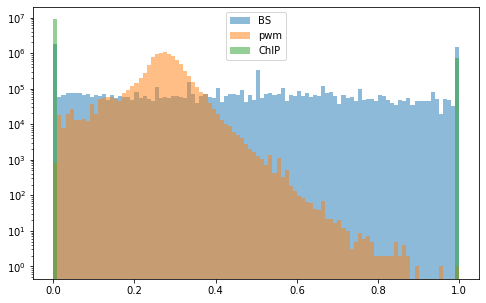

In [193]:
ss=data.groupby(['TF','gene']).agg({'pwm':'mean',"W1":'mean',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())
fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['mean pwm motif='+str(roc_auc2),'mean wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")

In [194]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('mean_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('mean_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

['max wgbs motif=0.722342834898407', 'max wgbs motif=0.4138085647374004']


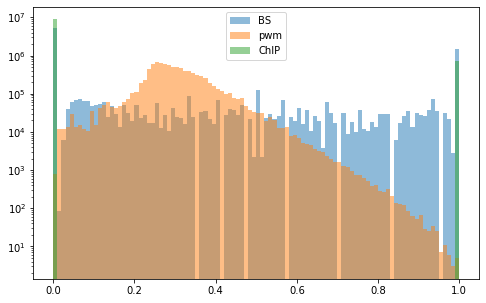

In [195]:
ss=data.groupby(['TF','gene']).agg({'pwm':'max',"W1":'max',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())
fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['max wgbs motif='+str(roc_auc2),'max wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")

In [196]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('max_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('max_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

['min wgbs motif=0.38440475373351285', 'min wgbs motif=0.7463724693730607']


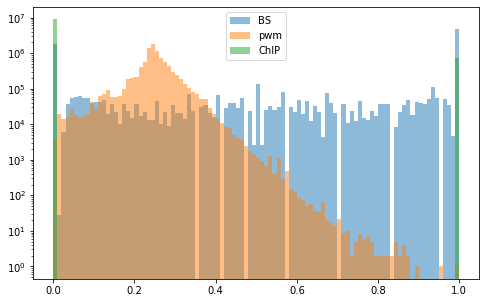

In [197]:
ss=data.groupby(['TF','gene']).agg({'pwm':'min',"W1":'min',"ChIPTF":'max'})
ss.pwm=(ss.pwm-ss.pwm.min())/(ss.pwm.max()-ss.pwm.min())

fpr, tpr, thresholds = metrics.roc_curve(ss.ChIPTF, 1-(ss.W1/100))
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(ss.ChIPTF, ss.pwm)
roc_auc2=metrics.auc(fpr2, tpr2)

print(['min wgbs motif='+str(roc_auc2),'min wgbs motif='+str(roc_auc)])

plt.figure(figsize=(8, 5))

ss.W1=np.round(1-(ss.W1/100),decimals=4)
ss.pwm=np.round(ss.pwm,decimals=4)

tmp=plt.hist(ss.W1,bins=100,label='BS',alpha=.5,log=True)
tmp=plt.hist(ss.pwm,bins=100,label='pwm',alpha=.5,log=True)
tmp=plt.hist(ss.ChIPTF,bins=100,label='ChIP',alpha=.5,log=True)

plt.legend(loc="best")

In [198]:
ss=ss.reset_index()
ss.TF=ss.TF.str.replace('(', '')
ss.TF=ss.TF.str.replace(')', '')
ss.TF=ss.TF.str.replace(' ', '')
ss.gene=ss.gene.str.replace(' ', '')
ss[['TF','gene','pwm']].to_csv('min_pwm_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')
ss[['TF','gene','W1']].to_csv('min_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')

In [142]:
ss['one']=1
ss[['TF','gene','one']].to_csv('one_wgbs_uniqMotif_BS_Chmax_refseq.txt',header=False,index=False,sep='\t')


## Run in Panda

In [157]:
def test_panda(motif,size):
    panda_objC=netZooPy.panda.Panda(expression_file='lcl_exp_panda.txt',
                          motif_file=motif,
                          ppi_file='ppi2015_freezeCellLine.txt',
                          computing='cpu',modeProcess='intersection',save_memory=False,save_tmp=False,
                          precision='single',keep_expression_matrix=False)

    if not os.path.exists('~/MIMB/bench/bench'+'/'+size):
        os.makedirs('~/MIMB/bench/bench'+'/'+size)
    panda_objC.export_panda_results.to_csv('~/MIMB/bench/'+size+'/'+motif,sep='\t',header=True,index=False)
    return panda_objC.export_panda_results

In [ ]:
#mean no buffer
test_panda('mean_pwm_uniqMotif_BS_Chmax_refseq.txt','mean_pwm')
test_panda('mean_wgbs_uniqMotif_BS_Chmax_refseq.txt','mean_wgbs')

test_panda('min_pwm_uniqMotif_BS_Chmax_refseq.txt','min_pwm')
test_panda('min_wgbs_uniqMotif_BS_Chmax_refseq.txt','min_wgbs')

test_panda('max_pwm_uniqMotif_BS_Chmax_refseq.txt','max_pwm')
test_panda('max_wgbs_uniqMotif_BS_Chmax_refseq.txt','max_wgbs')

test_panda('one_wgbs_uniqMotif_BS_Chmax_refseq.txt','one_motif')

# test_panda(min_0mean_pwm_motif,0bp_bench)
# test_panda(min_0max_one_motif,0bp_bench)

# ##max no buffer
# test_panda(min_0max_methyl_motif,0bp_bench)
# test_panda(min_0max_pwm_motif,0bp_bench)
# # test_panda(min_0max_one_motif,0bp_bench) not needed


# test_panda(min_0max_methyl_motif,0bp_bench)
# test_panda(min_0max_pwm_motif,0bp_bench)

# test_panda(min_0max_methyl_motif,0bp_bench)
# test_panda(min_0max_pwm_motif,0bp_bench)

# ##mean 100bp buffer
# test_panda(min_100mean_methyl_motif,100bp_bench)
# test_panda(min_100mean_pwm_motif,100bp_bench)
# test_panda(min_100mean_one_motif,100bp_bench)

# ##max 100bp buffer
# test_panda(min_100max_methyl_motif,100bp_bench)
# test_panda(min_100max_pwm_motif,100bp_bench)
# test_panda(min_100max_one_motif,100bp_bench)


In [189]:
mean_pwm=pd.read_csv('bench/mean_pwm_uniqMotif_BS_Chmax_refseq.txt',sep='\t',header=0,names=['TF','gene','motif','force'])
mean_wgbs=pd.read_csv('bench/mean_wgbs_uniqMotif_BS_Chmax_refseq.txt',sep='\t',header=0,names=['TF','gene','motif','force'])
mean=mean_pwm.merge(mean_wgbs,on=['TF','gene'])
test=mean.merge(ss[['TF','gene','ChIPTF']],on=['TF','gene'])

fpr, tpr, thresholds = metrics.roc_curve(test.ChIPTF, test.force_x)
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(test.ChIPTF, test.force_y)
roc_auc2=metrics.auc(fpr2, tpr2)
print(['mean panda pwm='+str(roc_auc),'mean panda wgbs='+str(roc_auc2)])

['pwm=0.4790298067333373', 'wgbs=0.6466127324501161']


In [192]:
max_pwm=pd.read_csv('bench/max_pwm_uniqMotif_BS_Chmax_refseq.txt',sep='\t',header=0,names=['TF','gene','motif','force'])
max_wgbs=pd.read_csv('bench/max_wgbs_uniqMotif_BS_Chmax_refseq.txt',sep='\t',header=0,names=['TF','gene','motif','force'])
max=max_pwm.merge(max_wgbs,on=['TF','gene'])
test=max.merge(ss[['TF','gene','ChIPTF']],on=['TF','gene'])

fpr, tpr, thresholds = metrics.roc_curve(test.ChIPTF, test.force_x)
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(test.ChIPTF, test.force_y)
roc_auc2=metrics.auc(fpr2, tpr2)
print(['min panda pwm='+str(roc_auc),'min panda wgbs='+str(roc_auc2)])

['min panda pwm=0.6169927216652102', 'min panda wgbs=0.4244881323117471']


In [191]:
min_pwm=pd.read_csv('bench/min_pwm_uniqMotif_BS_Chmax_refseq.txt',sep='\t',header=0,names=['TF','gene','motif','force'])
min_wgbs=pd.read_csv('bench/min_wgbs_uniqMotif_BS_Chmax_refseq.txt',sep='\t',header=0,names=['TF','gene','motif','force'])
min=min_pwm.merge(min_wgbs,on=['TF','gene'])
test=min.merge(ss[['TF','gene','ChIPTF']],on=['TF','gene'])

fpr, tpr, thresholds = metrics.roc_curve(test.ChIPTF, test.force_x)
roc_auc=metrics.auc(fpr, tpr)

fpr2, tpr2, thresholds2 = metrics.roc_curve(test.ChIPTF, test.force_y)
roc_auc2=metrics.auc(fpr2, tpr2)
print(['min panda pwm='+str(roc_auc),'min panda wgbs='+str(roc_auc2)])

['min panda pwm=0.39004939555510976', 'min panda wgbs=0.6706171522824088']


[0.4790298067333373, 0.6466127324501161]
